# Tohoku Notebook with Random Slip Fields

## Setup Environment

We assume you have installed `anuga` in your `python` environment. 

Some gauge data from  https://www.ngdc.noaa.gov/hazard/dart/2011honshu_dart.html and 
described in NOAA paper https://doi.org/10.1080/19475705.2011.632443. Also data is available from https://github.com/rjleveque/tohoku2011-paper1



### Setup inline graphics and animation

In [152]:
import os
import anuga
import numpy as np
import matplotlib.pyplot as plt


from setup_simulation import *


%matplotlib inline
%load_ext autoreload
%autoreload 2
#%load_ext memory_profiler

# Allow inline jshtml animations
from matplotlib import rc
rc('animation', html='jshtml')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Tohoku Folder

Change into the Tohoku folder (if you have not done that already)

In [153]:
try:
    os.chdir('Tohoku')
except:
    pass
print(f'Current directory {os.getcwd()}')




gauges = {}

# location of dart buoys
gauges[21401] =  Gauge(152.583, 42.617, t1 = 1800.)
gauges[21413] =  Gauge(152.1167, 30.5153, t1 = 1800.)
#gauges[21414] = [178.281, 48.938,  1800., 1.e10]
#gauges[21415] = [171.849, 50.183,  1800., 1.e10]
#gauges[21416] = [163.505, 48.052,  1800., 1.e10]
gauges[21418] =  Gauge(148.694, 38.711)
gauges[21419] =  Gauge(155.736, 44.455,  t1 = 1800.)
#gauges[51407] = [203.484, 19.642, 22000., 1.e10]
#gauges[52402] = [154.116, 11.883, 10000., 1.e10]

# location of integation points
gauges[0] = Gauge(141.0,38.0)
gauges[1] = Gauge(141.0,38.125)
gauges[2] = Gauge(141.0,38.25)



Current directory /home/steve/Tohoku


### Fault Parameters

In [154]:
# location of epicentre (absolute coordinates)
#x0 = 300000.0
#y0 = 250000.0
x0 = 720*km
y0 = 4200*km

km = 1000.0

# parameters of fault
parameters_small = dict(
    depth=15*km,
    length=100*km,
    width=30*km,
    strike=190.0,
    dip=15.0,
    rake=90.0,
    slip=30.0,
    opening=0.0,
    nu=0.25,
)


parameters = dict(
    depth=20*km,
    length=250*km,
    width=60*km,
    strike=195.0,
    dip=14.0,
    rake=87.0,
    slip=35.0,
    opening=0.0,
    nu=0.25,
)



## Setup Anuga Model

Create initial domain, then view Mesh and Elevation

Area of bounding polygon = 501600.00 km^2
Number of triangles: 82693
output directory: /home/steve/Tohoku/_output_Caltech
source directory: /home/steve/Tohoku/sources/Caltech.pts
project name:  Tohoku
Number of triangles =  87484
The extent is  (0.0, 880000.0, 0.0, 570000.0)
Geo reference is  (zone=54, easting=420000.000000, northing=3950000.000000, hemisphere=northern)
Figure files for each frame will be stored in _plot


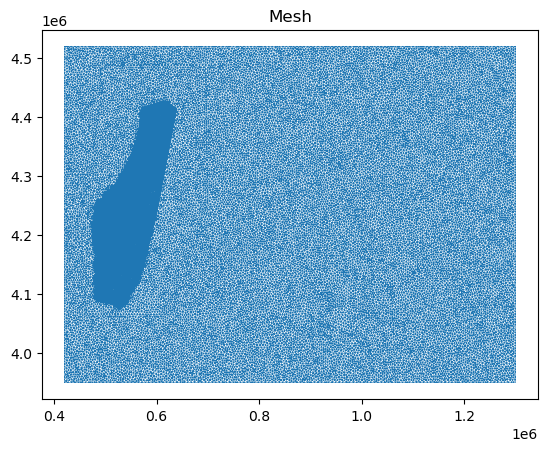

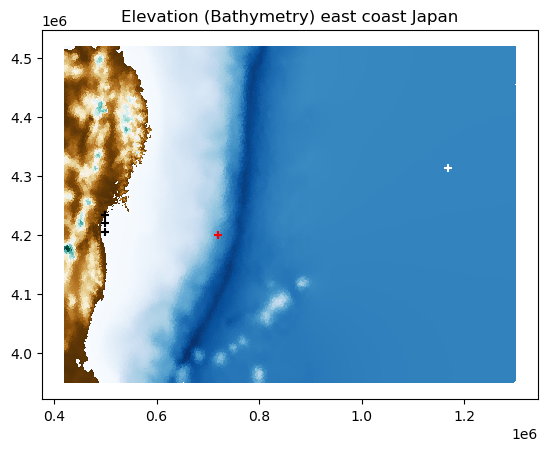

In [163]:
domain = create_domain()  


dplotter = anuga.Domain_plotter(domain, absolute=True)
plt.triplot(dplotter.triang, linewidth = 0.4)
plt.title('Mesh')

import cartopy
import cartopy.crs as ccrs

fig = plt.figure()
#ax = fig.add_subplot(111, projection=ccrs.UTM(zone=54))
ax = fig.add_subplot(111)

# Test for dry areas
md = 0.01

# Dry areas
dplotter.triang.set_mask(dplotter.depth > md)
ax.tripcolor(dplotter.triang,
                      facecolors=dplotter.elev,
                      cmap='BrBG')
                      #cmap='viridis_r')
                      #cmap='Greys_r')

# Wet Areas
dplotter.triang.set_mask(dplotter.depth <= md)
ax.tripcolor(dplotter.triang,
                      facecolors=dplotter.elev,
                      cmap='Blues_r')
                      #cmap='viridis')
                      #vmin=vmin, vmax=vmax)

dplotter.triang.set_mask(None)

# plot epicentre (absolute)

ax.scatter(x0, y0, marker='+', color='r')

# dart 21418 location 
ax.scatter(gauges[21418].east, gauges[21418].north, marker='+', color='w')

# locations on coast
ax.scatter(gauges[0].east, gauges[0].north, marker='+', color='k')
ax.scatter(gauges[1].east, gauges[1].north, marker='+', color='k')
ax.scatter(gauges[2].east, gauges[2].north, marker='+', color='k')


plt.title('Elevation (Bathymetry) east coast Japan');


### Setup random or QMC samplers

In [164]:
# we need to come up with a way to generate difference samples when running the notebook a second time. 
# Need a loop to generate the samples and then run the simulation for each sample.

from math import exp, sqrt
from scipy.stats import qmc

sample = 'random'
iseed = None
#sample = 'sobol'
#sample = None

E_subfault = 10
N_subfault = 10

# number of KL terms
N = E_subfault*N_subfault

if sample == 'sobol':
    sampler = qmc.Sobol(d=N, scramble=True, seed=iseed)
    
if sample == 'random':
    if iseed is not None:
        np.random.seed(iseed)
    sampler = np.random.default_rng()





### Create sample and create tsunami source

In [176]:
if sample == 'sobol':
    z = (sampler.random()).reshape((N,1))

if sample == 'random':
    z = (sampler.standard_normal(N)).reshape((N,1))



domain = create_domain()

apply_deformation(domain, z, parameters, x0, y0, E_subfault, N_subfault)


Area of bounding polygon = 501600.00 km^2
Number of triangles: 82693
output directory: /home/steve/Tohoku/_output_Caltech
source directory: /home/steve/Tohoku/sources/Caltech.pts
project name:  Tohoku
Number of triangles =  87484
The extent is  (0.0, 880000.0, 0.0, 570000.0)
Geo reference is  (zone=54, easting=420000.000000, northing=3950000.000000, hemisphere=northern)
Stage extent (orig) 1612.3264338944925 0.0
uZ extent           19.212264891962512 -11.501329567628712
Stage extent        1612.3508951670656 -11.501329567628712
Elevation extent    1612.3508951670656 -7944.9483192911


### View Stage after source has been applied

Figure files for each frame will be stored in _plot


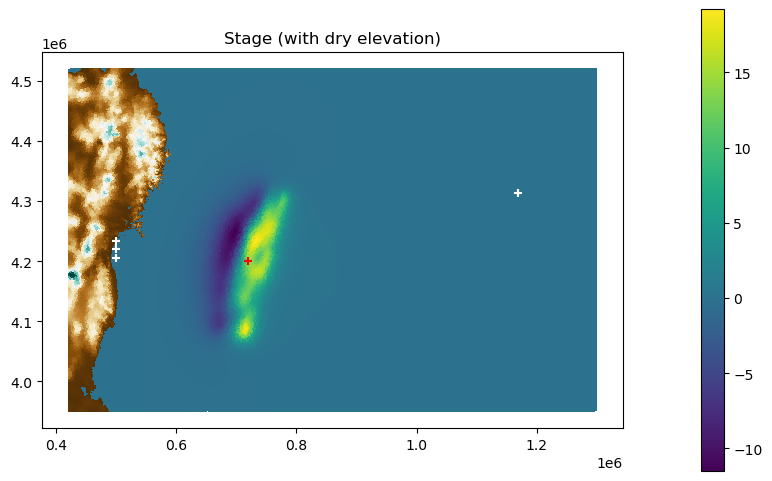

In [177]:
dplotter = anuga.Domain_plotter(domain, absolute=True)
# plt the updated elevation and stage
fig = plt.figure(figsize=(10,10))
#ax = fig.add_subplot(111, projection=ccrs.UTM(zone=54))
ax = fig.add_subplot(111)

md = 0.01

# dry areas
dplotter.triang.set_mask(dplotter.depth > md)
ax.tripcolor(dplotter.triang,
                      facecolors=dplotter.elev,
                      cmap='BrBG')
                      #cmap='viridis_r')
                      #cmap='Greys_r')


# wet areas
dplotter.triang.set_mask(dplotter.depth <= md)
img = ax.tripcolor(dplotter.triang,
                      facecolors=dplotter.stage,
                      #cmap='Blues_r')
                      cmap='viridis')
                      #vmin=vmin, vmax=vmax)

ax.set_aspect('equal', adjustable='box')

#fig.colorbar(img, pad = 0.2, shrink=0.6)
fig.colorbar(img, ax=ax, orientation='vertical', pad = 0.1, shrink=0.6)

ax.scatter(x0,y0,marker='+', color='r')

ax.scatter(gauges[21418].east, gauges[21418].north, marker='+', color='w')
ax.scatter(gauges[0].east, gauges[0].north, marker='+', color='w')
ax.scatter(gauges[1].east, gauges[1].north, marker='+', color='w')
ax.scatter(gauges[2].east, gauges[2].north, marker='+', color='w')

#ax.set_extent([400000,2500000,4000000, 4400000], crs=ccrs.UTM(zone=54))
#gridlines = ax.gridlines(draw_labels=True)



#ax.coastlines()

plt.title('Stage (with dry elevation)');

### Evolve the simulation

In [178]:
gauge_series, max_min_collector = evolve_domain(domain, gauges)

/home/steve/anuga_core/anuga/shallow_water/boundaries.py:1161: RuntimeWarning: invalid value encountered in multiply
  w1 = 0.0 - sqrt_g_on_depth_inside * stage_outside
/home/steve/anuga_core/anuga/shallow_water/boundaries.py:1165: RuntimeWarning: invalid value encountered in divide
  (n2 * Xmom.boundary_values[ids] - n1 * Ymom.boundary_values[ids])/depth_inside,
/home/steve/anuga_core/anuga/shallow_water/boundaries.py:1168: RuntimeWarning: invalid value encountered in divide
  w3 = ndotq_inside/depth_inside + sqrt_g_on_depth_inside*Stage.boundary_values[ids]


Time = 0.0000 (sec), steps=0 (17s)
Time = 120.0000 (sec), delta t in [1.73363884, 1.73363967] (s), steps=70 (2s)
Time = 240.0000 (sec), delta t in [1.73363628, 1.73363884] (s), steps=70 (3s)
Time = 360.0000 (sec), delta t in [1.73363550, 1.73363627] (s), steps=70 (3s)
Time = 480.0000 (sec), delta t in [1.73363520, 1.73363550] (s), steps=70 (2s)
Time = 600.0000 (sec), delta t in [1.73363504, 1.73363520] (s), steps=70 (2s)
Time = 720.0000 (sec), delta t in [1.73363501, 1.73363504] (s), steps=70 (2s)
Time = 840.0000 (sec), delta t in [1.73363504, 1.73363546] (s), steps=70 (2s)
Time = 960.0000 (sec), delta t in [1.73363547, 1.73363745] (s), steps=70 (2s)
Time = 1080.0000 (sec), delta t in [1.73363745, 1.73363813] (s), steps=70 (2s)
Time = 1200.0000 (sec), delta t in [1.73363813, 1.73363879] (s), steps=70 (2s)
Time = 1320.0000 (sec), delta t in [1.73363796, 1.73363886] (s), steps=70 (2s)
Time = 1440.0000 (sec), delta t in [1.73362669, 1.73363795] (s), steps=70 (2s)
Time = 1560.0000 (sec), d

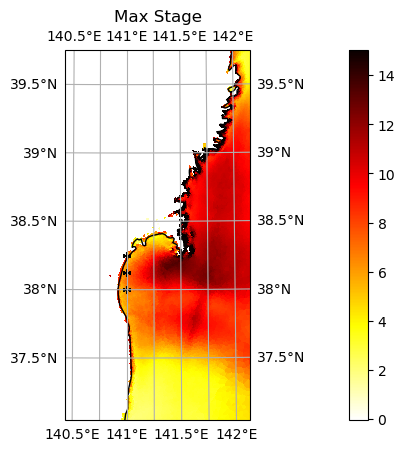

In [179]:
max_depth = max_min_collector.max_depth
max_stage = max_min_collector.max_stage

wet_mask = max_depth >= 0.01

wet_max_stage = np.where(max_depth >= 0.01, max_stage, np.nan)

fig = plt.figure()
ax = fig.add_subplot(111, projection=ccrs.UTM(zone=54))
#ax = fig.add_subplot(111)



img = ax.tripcolor(dplotter.triang,
                      facecolors=wet_max_stage,
                      #cmap='BrBG')
                      #cmap='viridis_r')
                      cmap='hot_r',
                      vmax=15.0)
                      #cmap='Greys_r')


# plot epicentre (absolute)
x0 = 720000.0
y0 = 4200000.0
ax.scatter(x0, y0, marker='+', color='r')

# dart 21418 location 
ax.scatter(gauges[21418].east, gauges[21418].north, marker='+', color='w')

# locations on coast
ax.scatter(gauges[0].east, gauges[0].north, marker='+', color='k')
ax.scatter(gauges[1].east, gauges[1].north, marker='+', color='k')
ax.scatter(gauges[2].east, gauges[2].north, marker='+', color='k')




ax.set_extent([450000,600000,4100000, 4400000], crs=ccrs.UTM(zone=54))
gridlines = ax.gridlines(draw_labels=True)

ax.coastlines()

plt.title('Max Stage')
plt.colorbar(img, pad = 0.2, shrink=1.0)



Text(0.5, 1.0, 'Comparison with 21418 data')

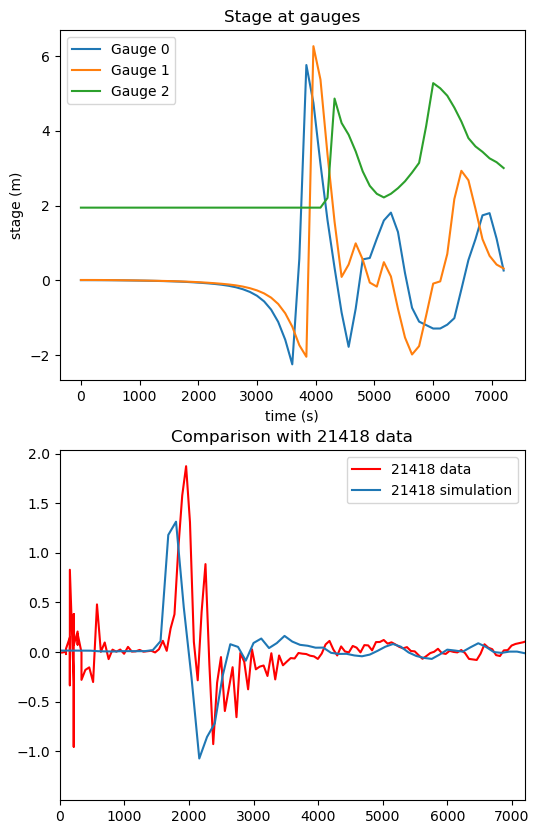

In [170]:
t = gauge_series[21418].time_series
stage_21418 = gauge_series[21418].stage_series
stage_0 = gauge_series[0].stage_series
stage_1 = gauge_series[1].stage_series
stage_2 = gauge_series[2].stage_series


fig = plt.figure(figsize=(6,10))


ax = fig.add_subplot(211)

ax.plot(t, stage_0, label='Gauge 0')
ax.plot(t, stage_1, label='Gauge 1')
ax.plot(t, stage_2, label='Gauge 2')

ax.set_xlabel('time (s)')
ax.set_ylabel('stage (m)')  
ax.legend()
ax.set_title('Stage at gauges')

ax = fig.add_subplot(212)
hour = 3600.0
xy = np.loadtxt('21418_notide.txt')

ax.plot(xy[:,0], xy[:,1], 'r', label='21418 data') 
ax.plot(t, stage_21418, label='21418 simulation')
ax.legend()
ax.set_xlim(0, 2*hour)
ax.set_title('Comparison with 21418 data')

Text(0.5, 1.0, 'Comparison with 21418 data')

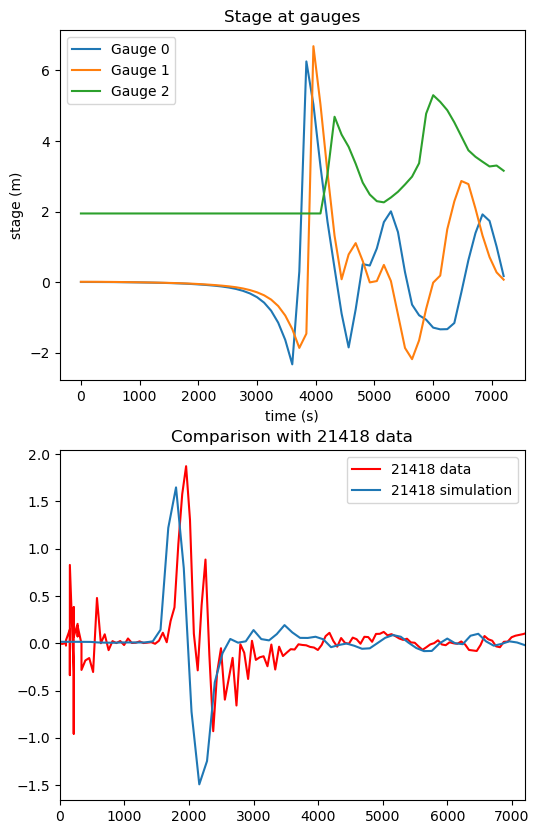

In [180]:
t = gauge_series[21418].time_series
stage_21418 = gauge_series[21418].stage_series
stage_0 = gauge_series[0].stage_series
stage_1 = gauge_series[1].stage_series
stage_2 = gauge_series[2].stage_series


fig = plt.figure(figsize=(6,10))


ax = fig.add_subplot(211)

ax.plot(t, stage_0, label='Gauge 0')
ax.plot(t, stage_1, label='Gauge 1')
ax.plot(t, stage_2, label='Gauge 2')

ax.set_xlabel('time (s)')
ax.set_ylabel('stage (m)')  
ax.legend()
ax.set_title('Stage at gauges')

ax = fig.add_subplot(212)
hour = 3600.0
xy = np.loadtxt('21418_notide.txt')

ax.plot(xy[:,0], xy[:,1], 'r', label='21418 data') 
ax.plot(t, stage_21418, label='21418 simulation')
ax.legend()
ax.set_xlim(0, 2*hour)
ax.set_title('Comparison with 21418 data')

In [16]:
# splotter = anuga.SWW_plotter('tohoku_source_example.sww')

# wet_mask = splotter.depth >= 0.01

# wet_stage = np.where(splotter.depth >= 0.01, splotter.stage, np.nan)

# wet_max_stage = np.nanmax(wet_stage, axis=0)

# wet_max_stage.shape


In [17]:
# fig = plt.figure()
# ax = fig.add_subplot(111, projection=ccrs.UTM(zone=54))
# #ax = fig.add_subplot(111)



# img = ax.tripcolor(dplotter.triang,
#                       facecolors=wet_max_stage,
#                       #cmap='BrBG')
#                       cmap='hot_r')
#                       #cmap='viridis_r')
#                       #cmap='Greys_r')


# # plot epicentre (absolute)
# x0 = 720000.0
# y0 = 4200000.0
# ax.scatter(x0, y0, marker='+', color='r')

# # dart 21418 location 
# ax.scatter(gauges[21418].east, gauges[21418].north, marker='+', color='w')

# # location on coast
# ax.scatter(gauges[0].east, gauges[0].north, marker='+', color='b')

# ax.scatter(gauges[1].east, gauges[1].north, marker='+', color='k')




# #ax.set_extent([450000,2000000,4000000, 4400000], crs=ccrs.UTM(zone=54))
# gridlines = ax.gridlines(draw_labels=True)

# #ax.coastlines()

# plt.title('Max Wet Stage')

# plt.colorbar(img, pad = 0.2, shrink=0.64)


In [21]:

from scipy.stats import qmc
N = 100
sobol_sampler = qmc.Sobol(d=N, scramble=True, seed=None)
z = (sobol_sampler.random()).reshape((N,1))

In [22]:
z.shape

(100, 1)